In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import math
from itertools import product

In [2]:
df = pd.read_csv("/kaggle/input/stocks/GE.csv", parse_dates = ["Date"])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-02-16,83.610001,84.540001,82.980003,84.050003,83.797150,4505900
1,2023-02-17,83.589996,83.820000,82.230003,83.040001,82.790192,4424200
2,2023-02-21,82.139999,83.379997,81.809998,82.260002,82.012535,4071800
3,2023-02-22,82.160004,84.330002,82.099998,83.190002,82.939735,8642500
4,2023-02-23,83.489998,84.410004,81.900002,82.940002,82.690483,8077200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Open       252 non-null    float64       
 2   High       252 non-null    float64       
 3   Low        252 non-null    float64       
 4   Close      252 non-null    float64       
 5   Adj Close  252 non-null    float64       
 6   Volume     252 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.9 KB


In [4]:
df.set_index("Date", inplace = True)
df.drop(["Volume", "Adj Close"], axis = 1, inplace = True)

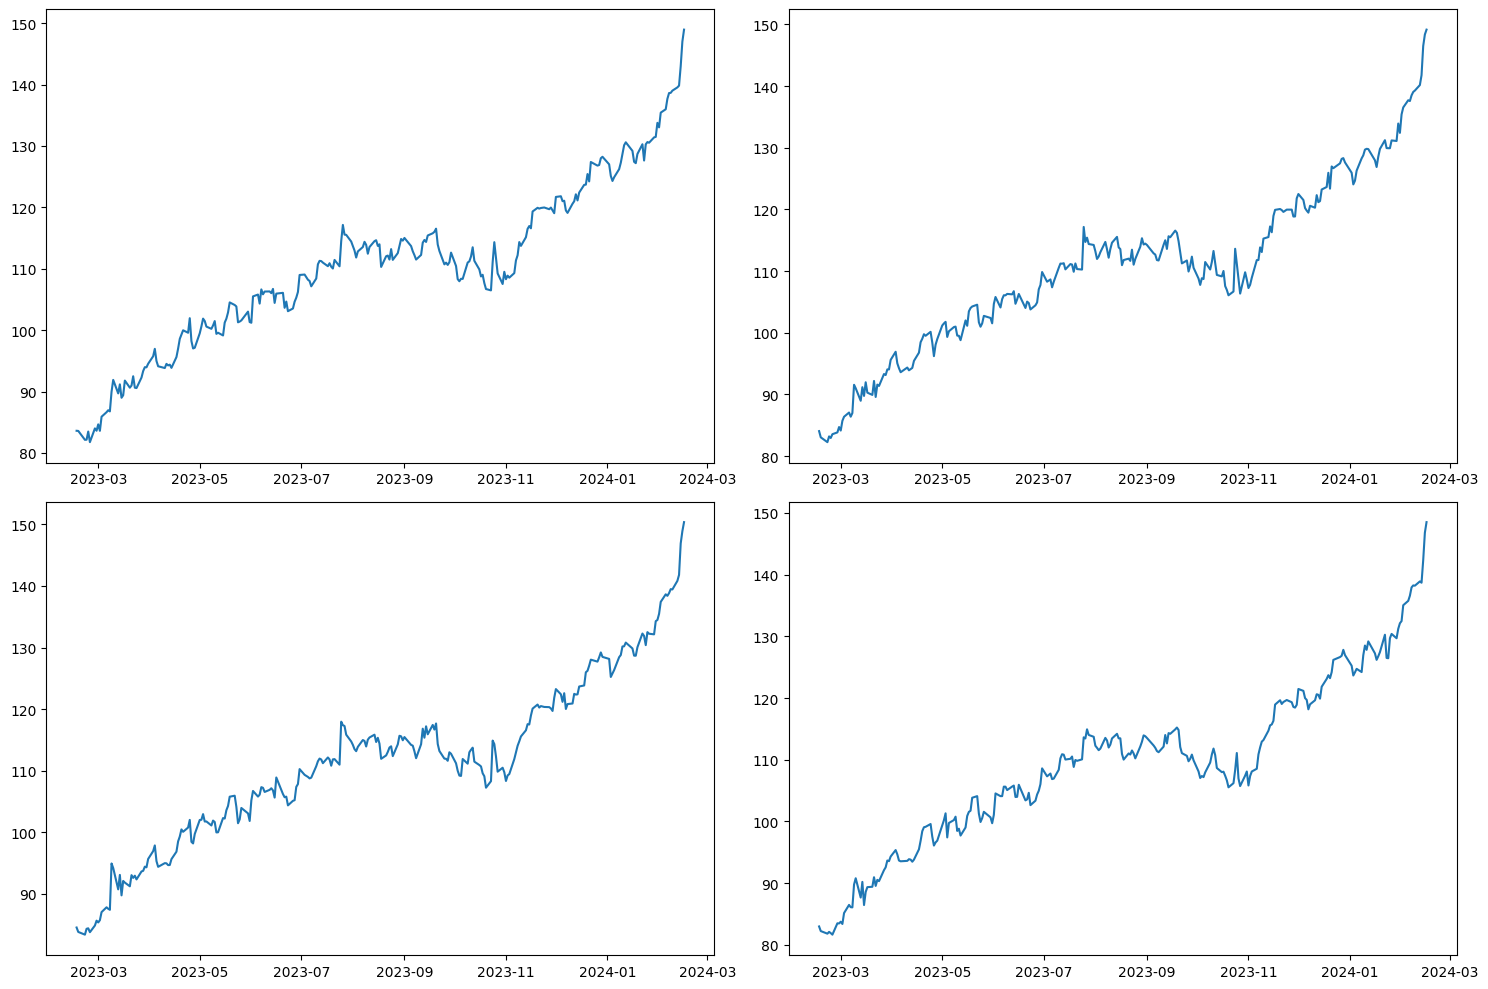

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(df.index, df['Open'], label='Open')
axs[0, 1].plot(df.index, df['Close'], label='Close')
axs[1, 0].plot(df.index, df['High'], label='High')
axs[1, 1].plot(df.index, df['Low'], label='Low')

plt.tight_layout()

plt.show()

In [6]:
decO = adfuller(df["Open"])
decC = adfuller(df["Close"])
decH = adfuller(df["High"])
decL = adfuller(df["Low"])
print(decO[1])
print(decC[1])
print(decH[1])
print(decL[1])

0.9873045943811621
0.984835258080787
0.98100450338628
0.9888746320631326


In [7]:
df["Open_diff1"] = df["Open"] - df["Open"].shift(1)
df["Close_diff1"] = df["Close"] - df["Close"].shift(1)
df["High_diff1"] = df["High"] - df["High"].shift(1)
df["Low_diff1"] = df["Low"] - df["Low"].shift(1)

In [8]:
decO = adfuller(df["Open_diff1"].dropna())
decC = adfuller(df["Close_diff1"].dropna())
decH = adfuller(df["High_diff1"].dropna())
decL = adfuller(df["Low_diff1"].dropna())
print(decO[1])
print(decC[1])
print(decH[1])
print(decL[1])

2.526690750444951e-05
1.0073299652386578e-18
2.3930540802321363e-29
2.2095458932270885e-28


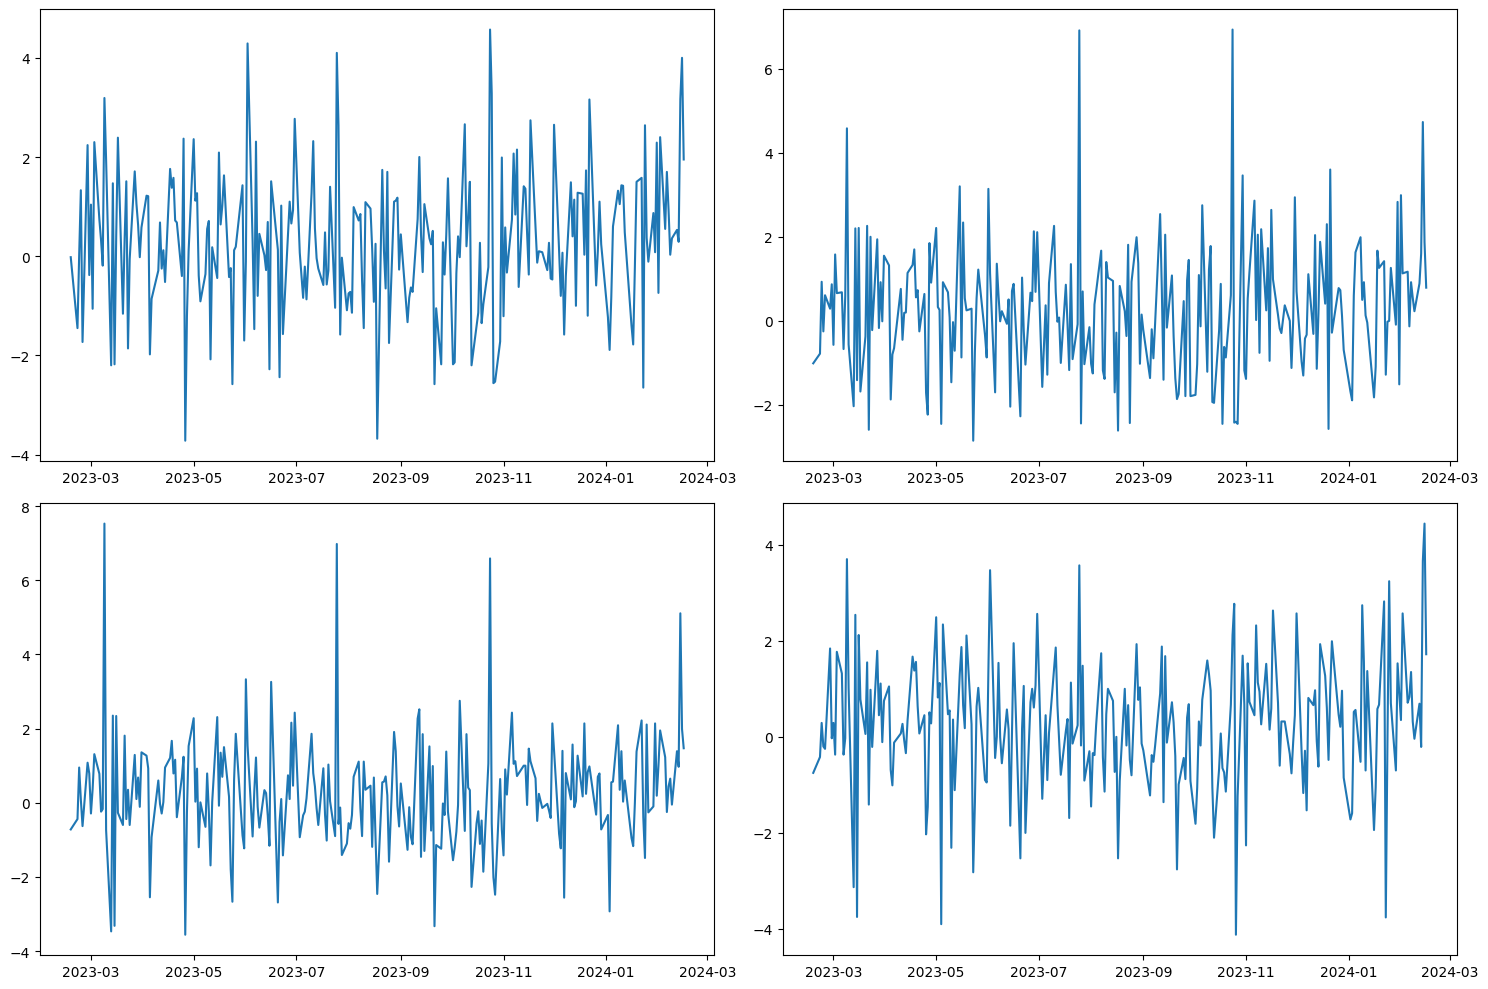

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(df.index, df['Open_diff1'], label='Open')
axs[0, 1].plot(df.index, df['Close_diff1'], label='Close')
axs[1, 0].plot(df.index, df['High_diff1'], label='High')
axs[1, 1].plot(df.index, df['Low_diff1'], label='Low')

plt.tight_layout()

plt.show()

In [10]:
trainsize = math.ceil(len(df) * 0.8)
train_df = df.iloc[:trainsize, :]
test_df = df.iloc[trainsize:, :]

In [11]:
len(test_df)

50

# VAR Model

In [12]:
model = VAR(train_df[["Open_diff1", "Close_diff1", "High_diff1", "Low_diff1"]].dropna())
result = model.fit(maxlags = 29)
result.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Feb, 2024
Time:                     13:04:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    6.23270
Nobs:                     172.000    HQIC:                   1.14327
Log likelihood:          -307.728    FPE:                   0.320811
AIC:                     -2.33142    Det(Omega_mle):       0.0402505
--------------------------------------------------------------------
Results for equation Open_diff1
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.058541         0.084427            0.693           0.488
L1.Open_diff1          -0.939801         0.228321           -4.116           0.000
L1.Close_diff1          1.044358         0.1922

In [13]:
forecast = result.forecast(train_df[["Open_diff1", "Close_diff1", "High_diff1", "Low_diff1"]].values, steps = 50)
forecast_df = pd.DataFrame(forecast, columns = ["Open_diff1", "Close_diff1", "High_diff1", "Low_diff1"])
forecast_df

,Open_diff1,Close_diff1,High_diff1,Low_diff1
0,1.061702,4.558376,3.545627,3.259189
1,0.469347,-4.685435,-2.708800,-3.249219
2,-3.063301,-0.395824,-0.209164,-1.276115
3,-0.315215,-1.700077,-2.867334,-1.210946
4,-2.271603,-0.590291,-0.754020,0.012862
5,-0.460573,0.770273,0.274278,-1.638711
6,1.736194,-0.755266,1.333778,0.875359
7,-0.847732,-0.710948,-1.146665,-0.951484
8,-1.042801,-1.551042,-1.389662,-2.642290
9,0.365660,3.280673,2.665230,2.295098


In [14]:
test_df

,Open,High,Low,Close,Open_diff1,Close_diff1,High_diff1,Low_diff1
Date,,,,,,,,
2023-12-06,121.080002,122.580002,119.699997,119.809998,0.070000,-0.420005,1.400002,-0.290001
2023-12-07,119.500000,120.019997,118.169998,119.480003,-1.580002,-0.329995,-2.560005,-1.529999
2023-12-08,119.099998,120.820000,118.980003,120.589996,-0.400002,1.109993,0.800003,0.810005
2023-12-11,120.589996,120.910004,119.639999,120.279999,1.489998,-0.309997,0.090004,0.659996
2023-12-12,120.989998,122.480003,120.610001,122.320000,0.400002,2.040001,1.569999,0.970002
2023-12-13,122.129997,122.360001,120.519997,121.180000,1.139999,-1.140000,-0.120002,-0.090004
2023-12-14,121.129997,122.400002,119.900002,121.349998,-1.000000,0.169998,0.040001,-0.619995
2023-12-15,122.410004,123.669998,121.830002,123.230003,1.280007,1.880005,1.269996,1.930000
2023-12-18,123.669998,123.839996,123.099998,123.639999,1.259994,0.409996,0.169998,1.269996


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

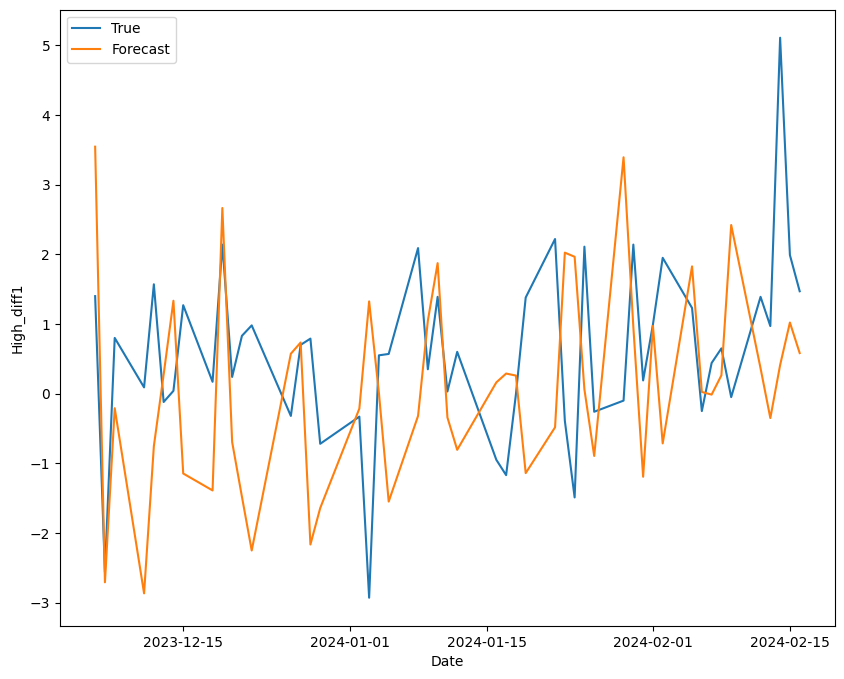

In [15]:
plt.figure(figsize = (10, 8))
sns.lineplot(x = test_df.index, y = test_df["High_diff1"], label = "True")
sns.lineplot(x = test_df.index, y = forecast_df["High_diff1"], label = "Forecast")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

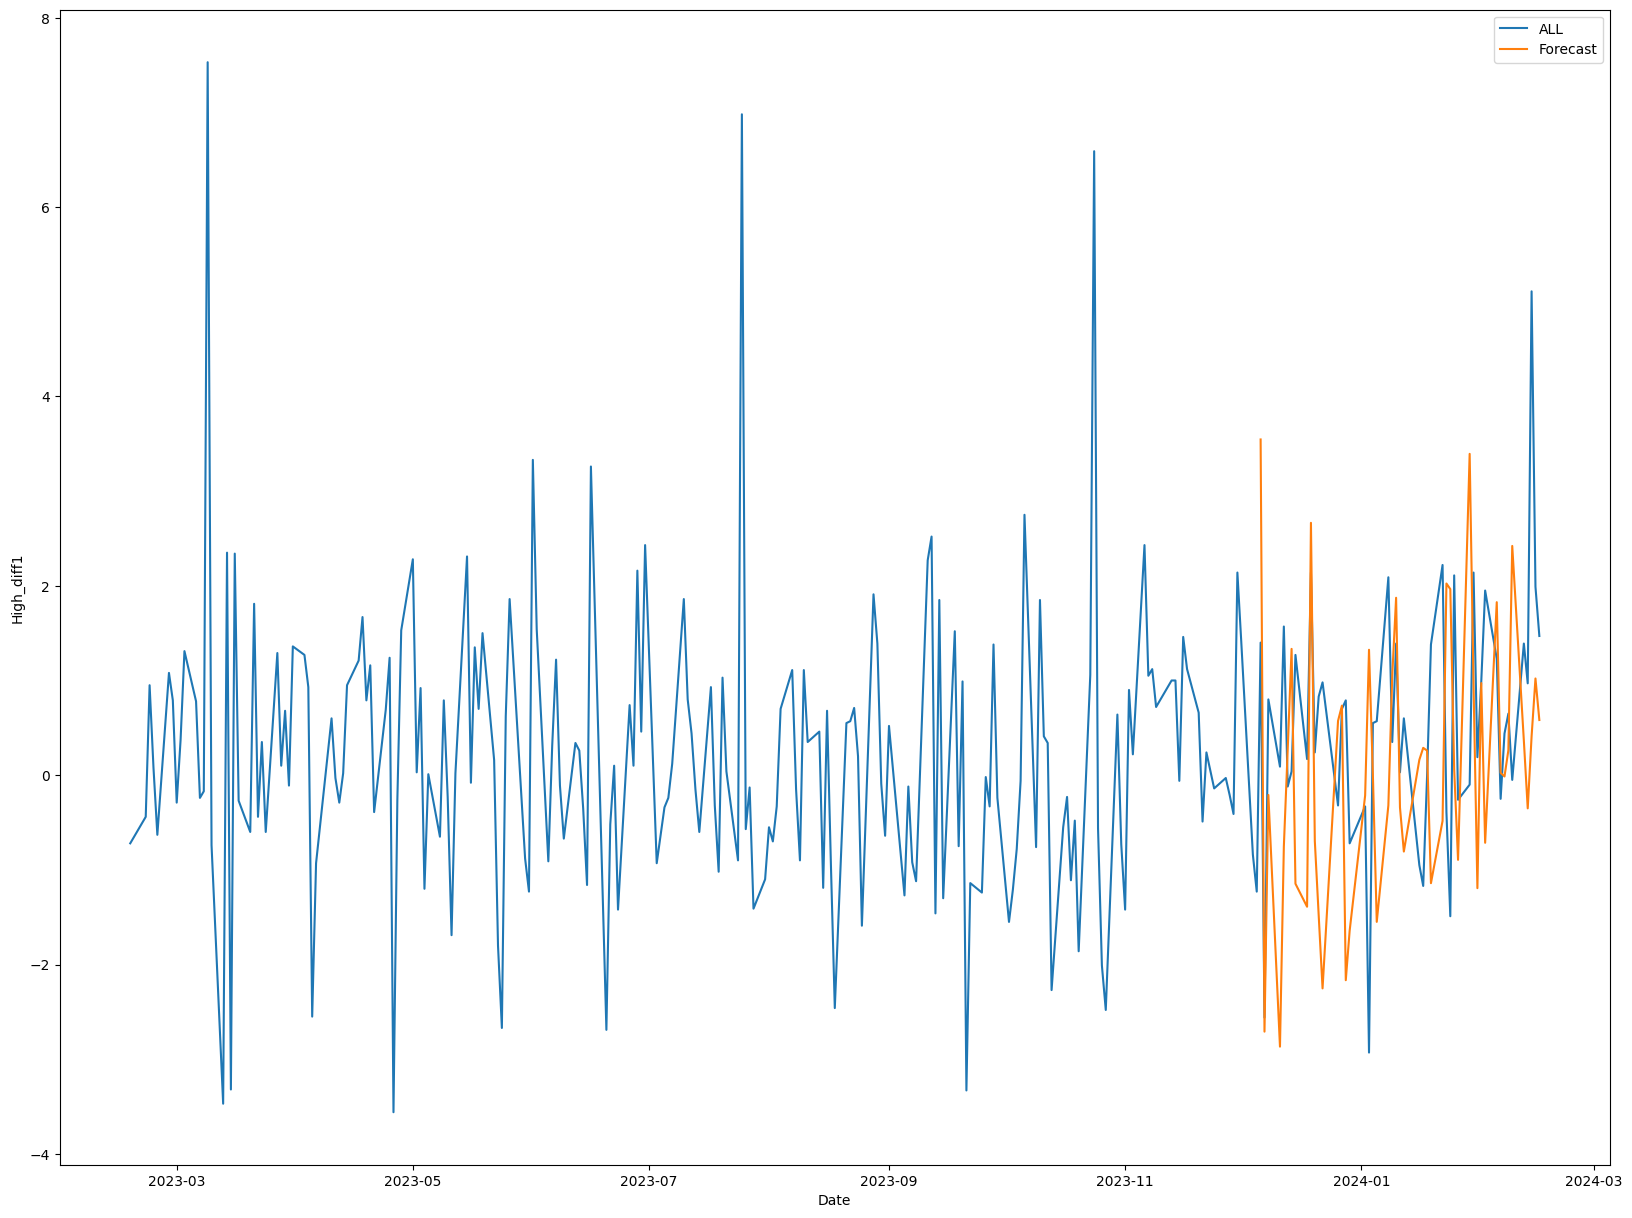

In [16]:
plt.figure(figsize = (20, 15))
sns.lineplot(x = df.index, y = df["High_diff1"], label = "ALL")
sns.lineplot(x = test_df.index, y = forecast_df["High_diff1"], label = "Forecast")
plt.show()

# VARMA Model

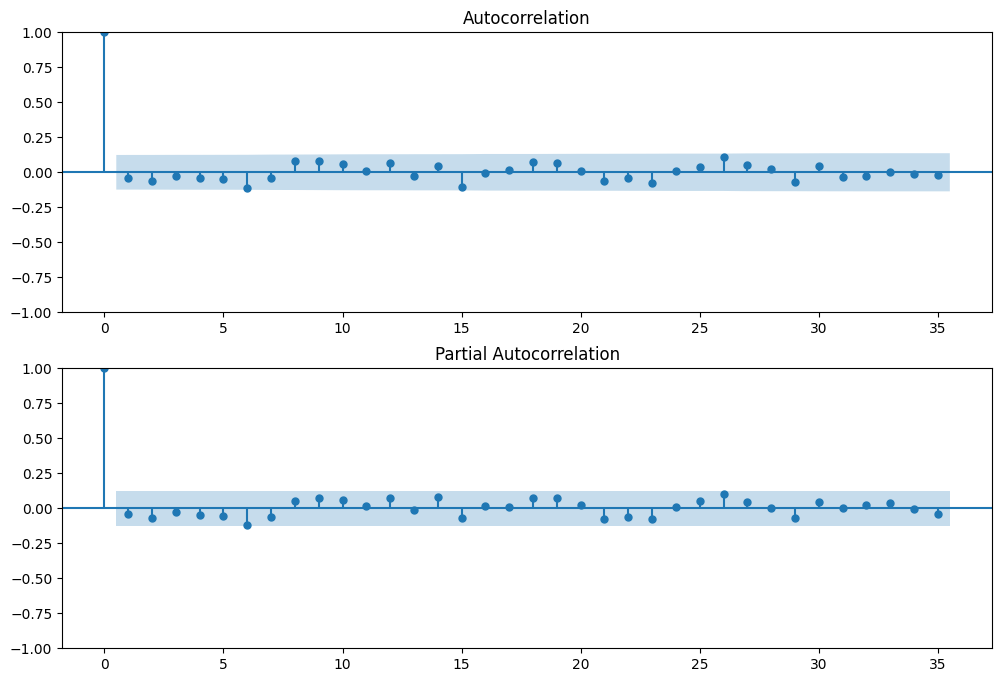

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['High_diff1'].dropna(),lags=35,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['High_diff1'].dropna(),lags=35,ax=ax2)

In [18]:
df2 = df.resample("W").mean()
df2.shape

(53, 8)

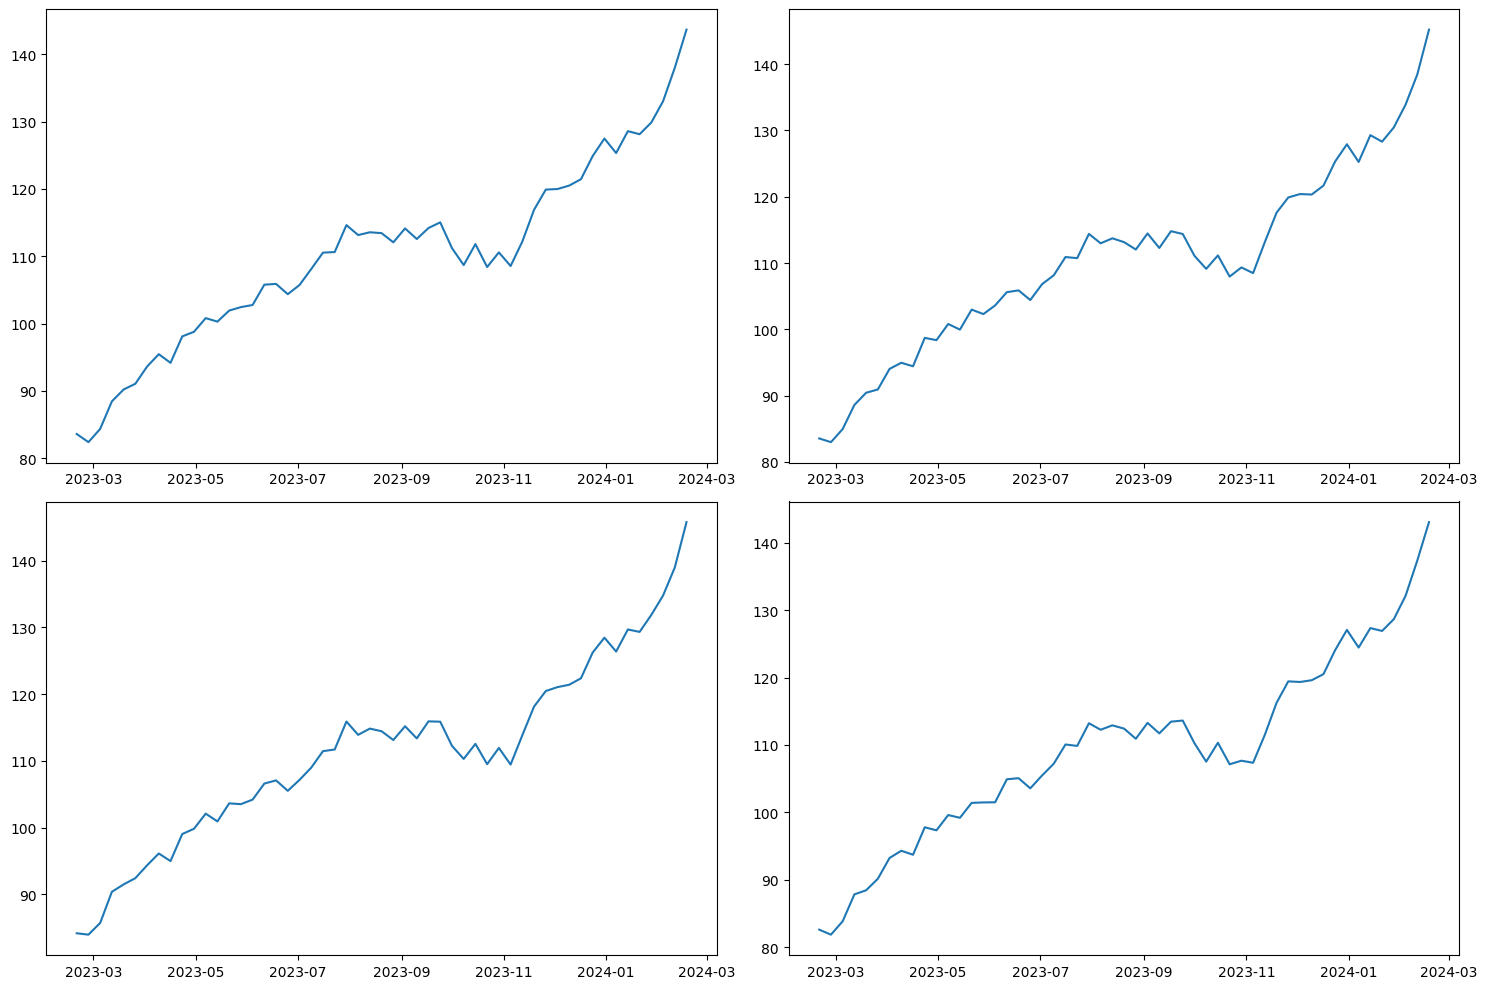

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(df2.index, df2['Open'], label='Open')
axs[0, 1].plot(df2.index, df2['Close'], label='Close')
axs[1, 0].plot(df2.index, df2['High'], label='High')
axs[1, 1].plot(df2.index, df2['Low'], label='Low')

plt.tight_layout()

plt.show()

In [20]:
decO = adfuller(df2["Open"])
decC = adfuller(df2["Close"])
decH = adfuller(df2["High"])
decL = adfuller(df2["Low"])
print(decO[1])
print(decC[1])
print(decH[1])
print(decL[1])

0.9840932929045111
0.988382314229008
0.9857968361539904
0.9855444447791609


In [21]:
df2["Open_diff1"] = df2["Open"] - df2["Open"].shift(1)
df2["Close_diff1"] = df2["Close"] - df2["Close"].shift(1)
df2["High_diff1"] = df2["High"] - df2["High"].shift(1)
df2["Low_diff1"] = df2["Low"] - df2["Low"].shift(1)

In [22]:
decO = adfuller(df2["Open_diff1"].dropna())
decC = adfuller(df2["Close_diff1"].dropna())
decH = adfuller(df2["High_diff1"].dropna())
decL = adfuller(df2["Low_diff1"].dropna())
print(decO[1])
print(decC[1])
print(decH[1])
print(decL[1])

9.788707618659663e-10
0.017212389551221313
0.0074127813306632505
1.7410047812127454e-08


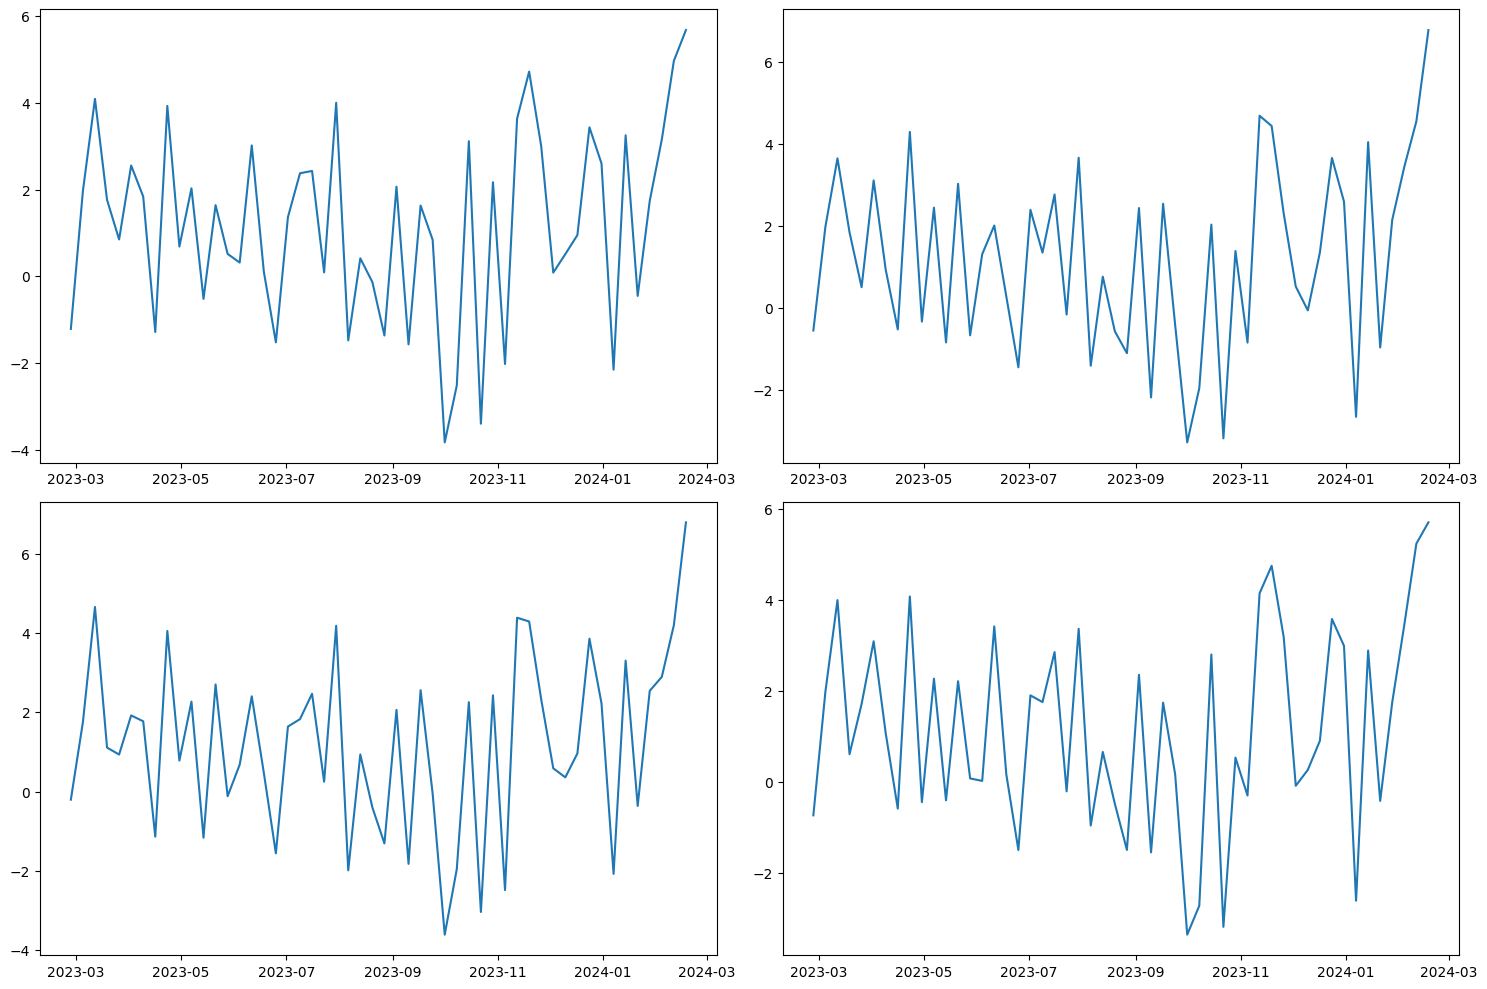

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(df2.index, df2['Open_diff1'], label='Open')
axs[0, 1].plot(df2.index, df2['Close_diff1'], label='Close')
axs[1, 0].plot(df2.index, df2['High_diff1'], label='High')
axs[1, 1].plot(df2.index, df2['Low_diff1'], label='Low')

plt.tight_layout()

plt.show()

In [24]:
trainsize = math.ceil(len(df2) * 0.7)
train_df2 = df2.iloc[:trainsize, :]
test_df2 = df2.iloc[trainsize:, :]

In [25]:
test_df2.shape

(15, 8)

In [26]:
'''p_values = range(1, 3) 
q_values = range(1, 3)  

best_aic = float('inf')
best_params = None

for p, q in product(p_values, q_values):
    model = VARMAX(train_df[["Open_diff1", "Close_diff1", "High_diff1", "Low_diff1"]].dropna(), order=(p, q))
    result = model.fit(disp=False)
    aic = result.aic
    if aic < best_aic:
        best_aic = aic
        best_params = (p, q)
        
print("Best Parameters (p, q):", best_params)'''

'p_values = range(1, 3) \nq_values = range(1, 3)  \n\nbest_aic = float(\'inf\')\nbest_params = None\n\nfor p, q in product(p_values, q_values):\n    model = VARMAX(train_df[["Open_diff1", "Close_diff1", "High_diff1", "Low_diff1"]].dropna(), order=(p, q))\n    result = model.fit(disp=False)\n    aic = result.aic\n    if aic < best_aic:\n        best_aic = aic\n        best_params = (p, q)\n        \nprint("Best Parameters (p, q):", best_params)'

In [27]:
model = VARMAX(train_df2[["Open_diff1", "Close_diff1", "High_diff1", "Low_diff1"]].dropna(), order=(3, 5), trend = 'n')
result = model.fit()
result.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          138     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78067D+00    |proj g|=  3.22973D+00


 This problem is unconstrained.



At iterate    5    f=  2.23065D+00    |proj g|=  1.38563D+00

At iterate   10    f=  1.83740D+00    |proj g|=  1.63686D+00

At iterate   15    f=  1.67495D+00    |proj g|=  1.72643D+00

At iterate   20    f=  1.56247D+00    |proj g|=  1.22930D+00

At iterate   25    f=  1.47447D+00    |proj g|=  2.01338D+00

At iterate   30    f=  1.40359D+00    |proj g|=  1.39106D+00

At iterate   35    f=  1.33205D+00    |proj g|=  7.24013D-01

At iterate   40    f=  1.27647D+00    |proj g|=  1.03844D+00

At iterate   45    f=  1.22234D+00    |proj g|=  1.13668D+00

At iterate   50    f=  1.16144D+00    |proj g|=  1.81102D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['Open_diff1', 'Close_diff1', 'High_diff1', 'Low_diff1']",No. Observations:,37
Model:,"VARMA(3,5)",Log Likelihood,-42.973
Date:,"Sat, 17 Feb 2024",AIC,361.946
Time:,13:05:17,BIC,584.253
Sample:,02-26-2023,HQIC,440.320
,- 11-05-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.35, 0.67, 0.36, 0.63",Jarque-Bera (JB):,"0.01, 2.45, 0.79, 0.46"
Prob(Q):,"0.56, 0.41, 0.55, 0.43",Prob(JB):,"0.99, 0.29, 0.67, 0.79"
Heteroskedasticity (H):,"0.42, 3.29, 0.46, 0.94",Skew:,"0.01, -0.23, 0.36, 0.06"
Prob(H) (two-sided):,"0.15, 0.05, 0.20, 0.91",Kurtosis:,"2.92, 4.17, 3.07, 2.47"


In [28]:
forecast = result.get_forecast( steps = 15)
forecast_values = forecast.predicted_mean
forecast_values

,Open_diff1,Close_diff1,High_diff1,Low_diff1
2023-11-12,2.731088,2.528124,3.560747,2.025169
2023-11-19,4.234534,3.436152,3.520031,3.160050
2023-11-26,-0.798346,-0.651631,-0.613187,0.072109
2023-12-03,0.984027,1.334954,0.773422,0.518604
2023-12-10,1.425714,1.090364,1.619710,1.985181
2023-12-17,-0.264009,0.053834,-0.442196,-0.335335
2023-12-24,0.909644,0.718583,1.274454,0.579830
2023-12-31,-0.040729,0.164504,-0.442639,0.351728
2024-01-07,0.136889,-0.012839,0.380626,0.059858
2024-01-14,0.351927,0.475035,0.290893,0.241459


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

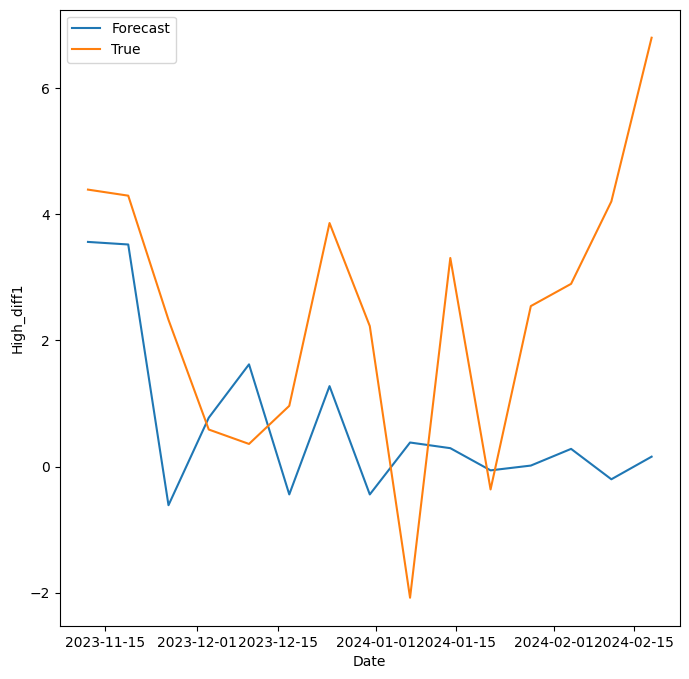

In [29]:
plt.figure(figsize = (8, 8))
sns.lineplot(x = test_df2.index, y = forecast_values["High_diff1"], label = "Forecast")
sns.lineplot(x = test_df2.index, y = test_df2["High_diff1"], label = "True")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

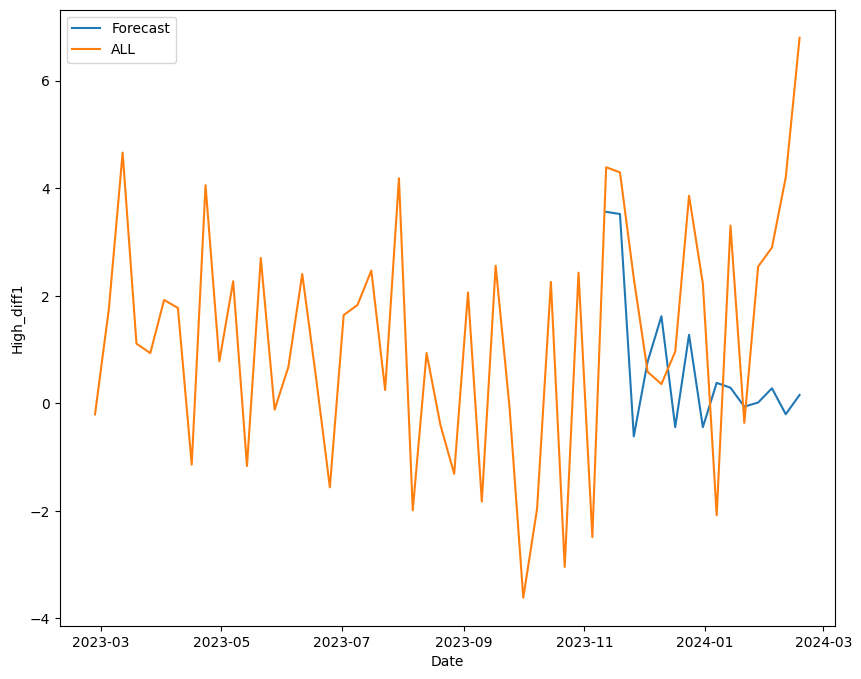

In [30]:
plt.figure(figsize = (10, 8))
sns.lineplot(x = test_df2.index, y = forecast_values["High_diff1"], label = "Forecast")
sns.lineplot(x = df2.index, y = df2["High_diff1"], label = "ALL")
plt.show()

with constant mean trean

In [31]:
model = VARMAX(train_df2[["Open_diff1", "Close_diff1", "High_diff1", "Low_diff1"]].dropna(), order=(2,3), trend = 'c')
result = model.fit()
result.summary()

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           94     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82971D+00    |proj g|=  2.33615D+00

At iterate    5    f=  2.31678D+00    |proj g|=  8.53904D-01

At iterate   10    f=  2.16649D+00    |proj g|=  3.64542D-01

At iterate   15    f=  2.04065D+00    |proj g|=  1.49275D+00

At iterate   20    f=  1.96426D+00    |proj g|=  8.29067D-01

At iterate   25    f=  1.87301D+00    |proj g|=  1.49186D+00

At iterate   30    f=  1.79800D+00    |proj g|=  7.82627D-01

At iterate   35    f=  1.72636D+00    |proj g|=  1.46295D+00

At iterate   40    f=  1.67112D+00    |proj g|=  7.17816D-01

At iterate   45    f=  1.63145D+00    |proj g|=  1.65571D+00

At iterate   50    f=  1.59630D+00    |proj g|=  3.03083D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['Open_diff1', 'Close_diff1', 'High_diff1', 'Low_diff1']",No. Observations:,37
Model:,"VARMA(2,3)",Log Likelihood,-59.063
,+ intercept,AIC,306.126
Date:,"Sat, 17 Feb 2024",BIC,457.552
Time:,13:05:29,HQIC,359.511
Sample:,02-26-2023,,
,- 11-05-2023,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.05, 0.12, 0.22, 0.05",Jarque-Bera (JB):,"0.35, 17.59, 0.06, 0.28"
Prob(Q):,"0.82, 0.73, 0.64, 0.82",Prob(JB):,"0.84, 0.00, 0.97, 0.87"
Heteroskedasticity (H):,"0.77, 1.73, 1.18, 0.53",Skew:,"0.21, 0.86, 0.06, 0.20"


In [32]:
forecast = result.get_forecast( steps = 15)
forecast_values = forecast.predicted_mean
forecast_values

,Open_diff1,Close_diff1,High_diff1,Low_diff1
2023-11-12,1.530196,1.298763,2.084726,2.021038
2023-11-19,2.607508,2.315692,2.505136,0.607608
2023-11-26,-1.021443,-1.032139,-1.224390,-0.012463
2023-12-03,0.714802,1.177422,0.631247,1.329704
2023-12-10,1.142447,0.371269,1.486413,-0.109498
2023-12-17,0.193558,0.645075,0.074115,0.618190
2023-12-24,-0.433214,-0.504598,-0.638456,-0.096651
2023-12-31,1.570308,1.510270,1.967238,1.046644
2024-01-07,0.215641,0.056276,-0.079642,0.269456
2024-01-14,-0.118123,0.110582,0.005149,0.063940


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

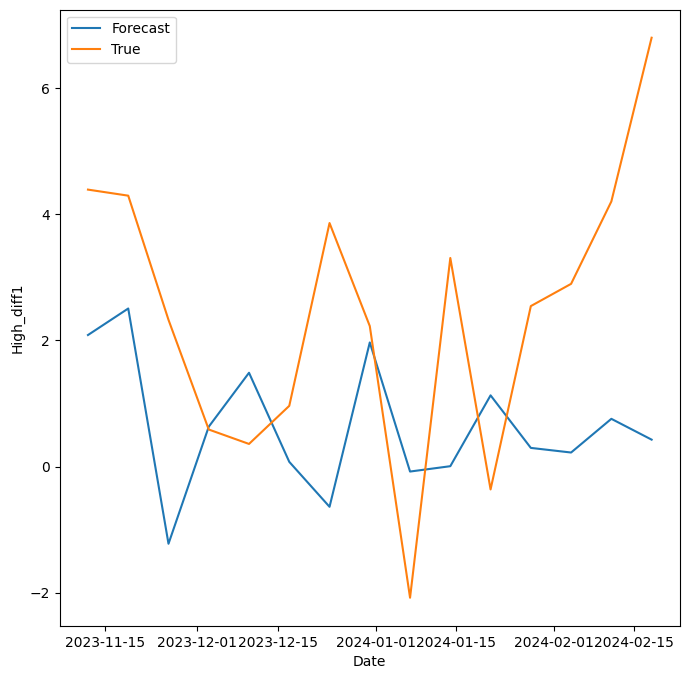

In [33]:
plt.figure(figsize = (8, 8))
sns.lineplot(x = test_df2.index, y = forecast_values["High_diff1"], label = "Forecast")
sns.lineplot(x = test_df2.index, y = test_df2["High_diff1"], label = "True")
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

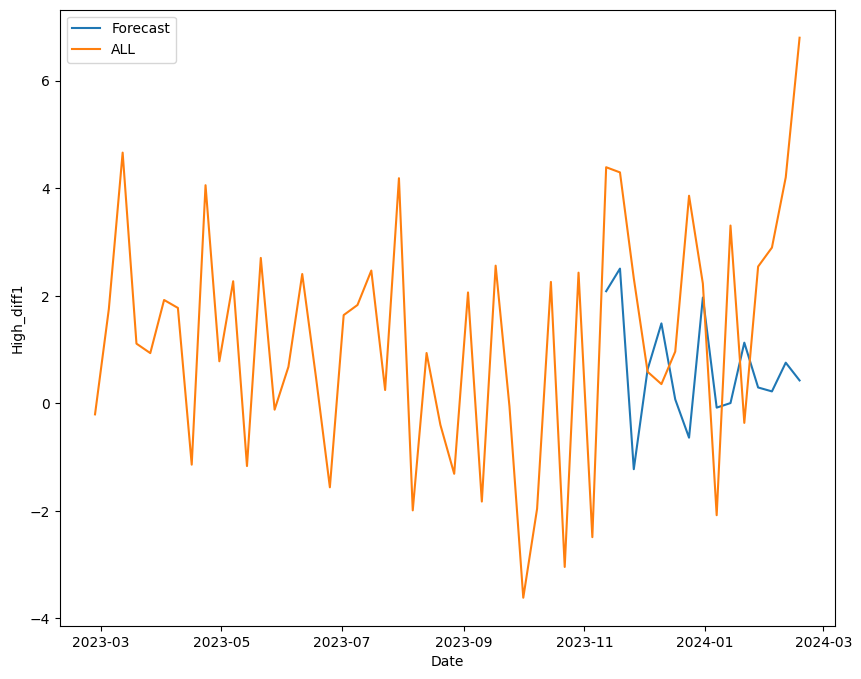

In [34]:
plt.figure(figsize = (10, 8))
sns.lineplot(x = test_df2.index, y = forecast_values["High_diff1"], label = "Forecast")
sns.lineplot(x = df2.index, y = df2["High_diff1"], label = "ALL")
plt.show()